# Predict alpha matte with trained model

This is the 4th step in our workflow to remove the background from an image:

4. Predict alpha matte of an image and get image cutout

## Sources:
* [MODNet GitHub](https://github.com/ZHKKKe/MODNet)


# Import

In [3]:
# import modules to handle files
import os
import glob
import shutil
from google.colab import drive
from PIL import Image

# import modules to train models
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import pandas as pd
import numpy as np

# Mount Google Drive

In [4]:
drive.mount('/content/drive/')

Mounted at /content/drive/


# Clone MODNet repo & download pre-trained model

In [5]:
# clone the repository
%cd /content
if not os.path.exists('MODNet'):
  !git clone https://github.com/ZHKKKe/MODNet
%cd MODNet/

/content
Cloning into 'MODNet'...
remote: Enumerating objects: 213, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 213 (delta 1), reused 0 (delta 0), pack-reused 206
Receiving objects: 100% (213/213), 37.62 MiB | 28.08 MiB/s, done.
Resolving deltas: 100% (63/63), done.
/content/MODNet


In [6]:
os.getcwd()

'/content/MODNet'

In [7]:
# copy pre-trained model to directory
current_path = "/content/drive/MyDrive/Faktion/exploration/pretrained_models/mobilenetv2_human_seg.ckpt"
dst_path = "/content/MODNet/pretrained/mobilenetv2_human_seg.ckpt"
shutil.copy(current_path, dst_path)

'/content/MODNet/pretrained/mobilenetv2_human_seg.ckpt'

# Train model to predict alpha matte

## Functions

In [8]:
def process_image(image):
  """
  Function to process image into the input format required
  for model
  """
  
  # # read image
  # image = Image.open(image_path)


  # define image to tensor transform
  im_transform = transforms.Compose(
      [
          transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
      ])

  # unify image channels to 3
  image = np.asarray(image)
  if len(image.shape) == 2:
      image = image[:, :, None]
  if image.shape[2] == 1:
      image = np.repeat(image, 3, axis=2)
  elif image.shape[2] == 4:
      image = image[:, :, 0:3]

  # convert image to PyTorch tensor
  image = Image.fromarray(image)
  image = im_transform(image).cuda()

  # add mini-batch dim
  image = image[None, :, :, :]

  # resize image for input
  im_b, im_c, im_h, im_w = image.shape
  ref_size = 512
  if max(im_h, im_w) < ref_size or min(im_h, im_w) > ref_size:
      if im_w >= im_h:
          im_rh = ref_size
          im_rw = int(im_w / im_h * ref_size)
      elif im_w < im_h:
          im_rw = ref_size
          im_rh = int(im_h / im_w * ref_size)
  else:
      im_rh = im_h
      im_rw = im_w

  im_rw = im_rw - im_rw % 32
  im_rh = im_rh - im_rh % 32
  image = F.interpolate(image, size=(im_rh, im_rw), mode='area')

  return image

# Load model
Parameters for PyTorch networks stored in the model's `state_dict`

[Source](https://colab.research.google.com/github/agungsantoso/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/Part%206%20-%20Saving%20and%20Loading%20Models.ipynb#scrollTo=lBqSgQCNpCX4)

In [9]:
# cd to repository
%cd ..
%cd /content/MODNet/

# import local module: MODNet
from src.models.modnet import MODNet

/content
/content/MODNet


In [10]:
# define device
device = "cuda" if torch.cuda.is_available() else "cpu"

# rebuild model with same architecture as in training
modnet = torch.nn.DataParallel(MODNet()).to(device)

# load model's state_dict
state_dict = torch.load(
    '/content/drive/MyDrive/Faktion/exploration/model_checkpoint.pth',
    map_location=torch.device(device) # map to device
    )
print(state_dict.keys())

# load state_dict into the network (works only if model architecture is the same as checkpoint architecture)
modnet.load_state_dict(state_dict)

odict_keys(['module.backbone.model.features.0.0.weight', 'module.backbone.model.features.0.1.weight', 'module.backbone.model.features.0.1.bias', 'module.backbone.model.features.0.1.running_mean', 'module.backbone.model.features.0.1.running_var', 'module.backbone.model.features.0.1.num_batches_tracked', 'module.backbone.model.features.1.conv.0.weight', 'module.backbone.model.features.1.conv.1.weight', 'module.backbone.model.features.1.conv.1.bias', 'module.backbone.model.features.1.conv.1.running_mean', 'module.backbone.model.features.1.conv.1.running_var', 'module.backbone.model.features.1.conv.1.num_batches_tracked', 'module.backbone.model.features.1.conv.3.weight', 'module.backbone.model.features.1.conv.4.weight', 'module.backbone.model.features.1.conv.4.bias', 'module.backbone.model.features.1.conv.4.running_mean', 'module.backbone.model.features.1.conv.4.running_var', 'module.backbone.model.features.1.conv.4.num_batches_tracked', 'module.backbone.model.features.2.conv.0.weight', 'm

<All keys matched successfully>

# Predict alpha matte with trained model

## Predict alpha matte of one test image

In [12]:
# path to image
image_path = "/content/drive/MyDrive/BeCode/Projects/Faktion/exploration/0002-01.jpeg"

# process image into correct input format for model
im = process_image(image_path)

# predict alpha matte
_, _, matte = modnet(im, True)

# load image to get the original shape
image = np.asarray(Image.open(image_path))
print(image.shape)

# resize alpha matte to the original shape
im_h = image.shape[0]
im_w = image.shape[1]
matte = F.interpolate(matte, size=(im_h, im_w), mode='area')
matte = matte[0][0].data.cpu().numpy()
print(matte.shape)

# save matte
matte_name = 'test.png'
Image.fromarray(((matte * 255).astype('uint8')), mode='L').save(os.path.join("/content", matte_name))

IndexError: ignored

## Visualization

In [ ]:
def visualize_results(image, matte) -> tuple:
  """
  Function to visualize results
  
  returns: tuple of images:
  * image cutout
  * image combining original image, image cutout, predicted alpha matte
  """
  # calculate display resolution
  print(image.shape)
  h, w = image.shape[0], image.shape[1]
  rw, rh = 800, int(h * 800 / (3 * w))
  
  # obtain predicted foreground
  image = np.asarray(image)
  if len(image.shape) == 2:
    image = image[:, :, None]
  if image.shape[2] == 1:
    image = np.repeat(image, 3, axis=2)
  elif image.shape[2] == 4:
    image = image[:, :, 0:3]
  matte = np.repeat(np.asarray(matte)[:, :, None], 3, axis=2) / 255
  foreground = image * matte + np.full(image.shape, 255) * (1 - matte)
  
  # combine image, foreground, and alpha into one line
  combined = np.concatenate((image, foreground, matte * 255), axis=1)
  combined = Image.fromarray(np.uint8(combined)).resize((rw, rh))

  foreground = Image.fromarray(np.uint8(foreground))
  return combined, foreground

# visualize image cutout
matte = np.asarray(Image.open("/content/test.png"))
display(combined_display(image, matte)[1])

(657, 800, 3)


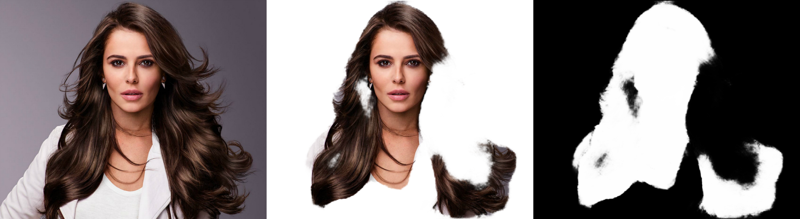

In [ ]:
# visualize original image, image cutout & predicted alpha matte
display(combined_display(image, matte)[0])

## Predict alpha matte of all images in DUTS test dataset

### Get image paths

In [ ]:
# load csv into dataframe
image_path_df = pd.read_csv("/content/drive/MyDrive/BeCode/Projects/Faktion/exploration/image_paths.csv")

In [ ]:
# display dataframe info
image_path_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10553 entries, 0 to 10552
Data columns (total 4 columns):
 #   Column                                                                      Non-Null Count  Dtype 
---  ------                                                                      --------------  ----- 
 0   /content/drive/MyDrive/BeCode/Projects/Faktion/DUTS/DUTS-TR/DUTS-TR-Image   10553 non-null  object
 1   filename                                                                    10553 non-null  object
 2   /content/drive/MyDrive/BeCode/Projects/Faktion/DUTS/DUTS-TR/DUTS-TR-Trimap  10553 non-null  object
 3   /content/drive/MyDrive/BeCode/Projects/Faktion/DUTS/DUTS-TR/DUTS-TR-Mask    10553 non-null  object
dtypes: object(4)
memory usage: 329.9+ KB


In [ ]:
def predict_alpha_matte(image_path, dst_dir) -> None:
  """
  Function to:
  * predict the alpha matte from original image
  * and save it into destination directory

  returns: None
  """
  # load image
  image = np.asarray(Image.open(image_path))
  
  # get image shape
  print("original image shape: ", image.shape)
  im_h = image.shape[0]
  im_w = image.shape[1]

  # process image into correct input format for model
  image = process_image(image)

  # predict alpha matte
  _, _, matte = modnet(image, True)

  # resize alpha matte to the original image shape
  matte = F.interpolate(matte, size=(im_h, im_w), mode='area')

  # convert alpha matte into 2d array
  matte = matte[0][0].data.cpu().numpy()
  print(matte.shape)

  # save alpha matte
  ## create destination directory if doesn't exist
  if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)

  # get alpha matte filename
  matte_name = image_path.split(os.sep)[-1]

  # save alpha matte
  Image.fromarray(((matte * 255).astype('uint8')), mode='L').save(os.path.join(dst_dir, matte_name))

In [ ]:
# set directory where to save the predicted alpha matte
dst_dir = "/content/test"

# get each original image path
for image_path in image_path_df.iloc[:,0].values:
  predict_alpha_matte(image_path, dst_dir)

# Performance metrics

## Functions

In [ ]:
def compute_mse(predicted_alpha, trimap, gt_alpha) -> float:
  """
  Function to compute the Mean Squared Error (MSE) error from:
  * predicted alpha matte
  * trimap image
  * ground truth alpha matte
  """
    num_pixels = float((trimap == 127).sum())
    mse = ((predicted_alpha - gt_alpha) ** 2).sum() / num_pixels
    return mse

def compute_sad(predicted_alpha, gt_alpha) -> float:
  """
  Function to compute the Sum of Absolute Differences (SAD) error from:
  * predicted alpha matte
  * ground truth alpha matte
  """
    diff = np.abs(predicted_alpha - gt_alpha)
    sad = np.sum(diff) / 1000
    return sad

def compute_mad():
  """
  Function to compute the Mean Abolute Difference (MAD)
  """
  pass

## Compute metrics

In [ ]:
compute_sad()